<a href="https://colab.research.google.com/github/aadityane93/ml/blob/main/Stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing files from Google Collab

In [1]:
#Giving access to the metroPT3.csv in google coolab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Get the file
downloaded = drive.CreateFile({'id':'1WZT2g06H_SXu0q5PgTFXbbUVsP6MuWkU'})
downloaded.GetContentFile('dataset-stroke.csv')
model_file = drive.CreateFile({'id':'1aW64ncd1YncPEW0GWos3PjUeNaJcXMcq'})
model_file.GetContentFile('stroke_xgb_model.pkl')

# Importing Python Libraries



In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pickle
import random

In [3]:
train_data = pd.read_csv(('dataset-stroke.csv'), sep=',', header=0)
df= df_for_decoding = pd.DataFrame(train_data)
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [4]:
df['bmi'].isnull().sum()

201

In [5]:
df['stroke'].value_counts()

,count
stroke,
0,4861
1,249


In [6]:
df['bmi'].mean()

28.893236911794666

In [7]:
df['avg_glucose_level'].mean()

106.1476771037182

In [8]:
# df.dropna(inplace=True)
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

df.isnull().sum()

<ipython-input-8-8427c8f0afc1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)


,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


In [9]:
df['smoking_status'].value_counts()


,count
smoking_status,
never smoked,1892
Unknown,1544
formerly smoked,885
smokes,789


In [10]:
df_stroke = df[df['stroke'] == 1]
df_stroke.drop(columns='id', inplace=True)
df_stroke.head()

<ipython-input-10-ea978acf7272>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stroke.drop(columns='id', inplace=True)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [11]:
df_stroke['work_type'].value_counts()

,count
work_type,
Private,149
Self-employed,65
Govt_job,33
children,2


In [12]:
df.drop(columns='id',inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


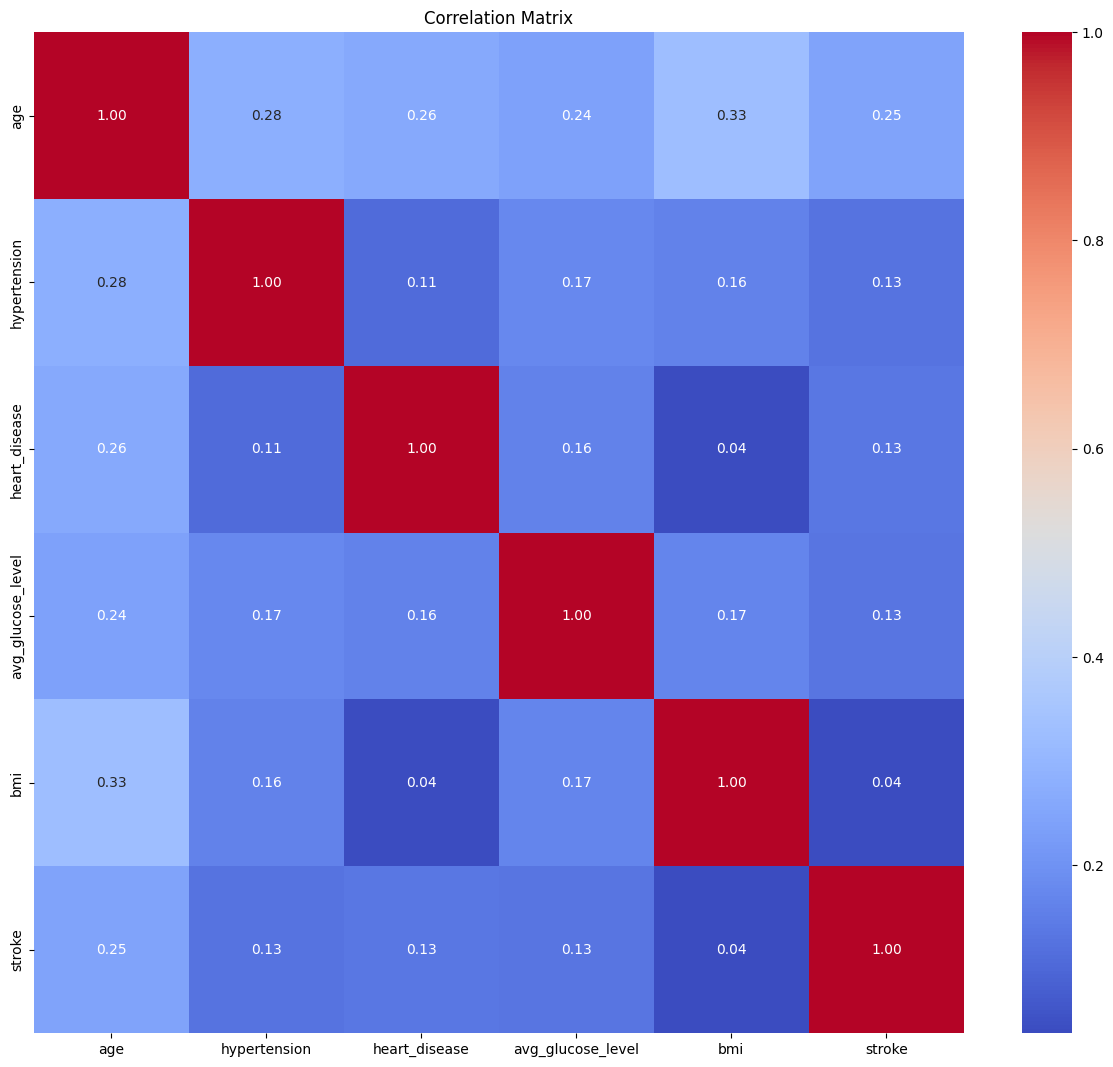

In [13]:
numerical_df = df.select_dtypes(include=['number'])
correlations = numerical_df.corr()
plt.figure(figsize=(15, 13))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [14]:
label_encoder = LabelEncoder()
columns_to_label = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for column in columns_to_label:
    label_encoder.fit(df[column])
    print(f"Column: {column}")
    for label, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
        print(f"  {label} -> {encoded}")
    print()


Column: gender
  Female -> 0
  Male -> 1
  Other -> 2

Column: ever_married
  No -> 0
  Yes -> 1

Column: work_type
  Govt_job -> 0
  Never_worked -> 1
  Private -> 2
  Self-employed -> 3
  children -> 4

Column: Residence_type
  Rural -> 0
  Urban -> 1

Column: smoking_status
  Unknown -> 0
  formerly smoked -> 1
  never smoked -> 2
  smokes -> 3



In [15]:
#Labelencoder
label_encoder = LabelEncoder()
columns_to_label = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for column in columns_to_label:
    df[column] = df[column].astype(str)
    df_stroke[column] = df_stroke[column].astype(str)
    df[column] = label_encoder.fit_transform(df[column])
    df_stroke[column] = label_encoder.fit_transform(df_stroke[column])

<ipython-input-15-f6c0af3ce3d2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stroke[column] = df_stroke[column].astype(str)
<ipython-input-15-f6c0af3ce3d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stroke[column] = label_encoder.fit_transform(df_stroke[column])
<ipython-input-15-f6c0af3ce3d2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [16]:
df
original = df.copy(deep=False)

In [17]:
df['stroke'].value_counts()

,count
stroke,
0,4861
1,249


In [18]:
# numerical_features = df.select_dtypes(include=['number'])
# sns.pairplot(numerical_features, diag_kind='kde')
# plt.show()

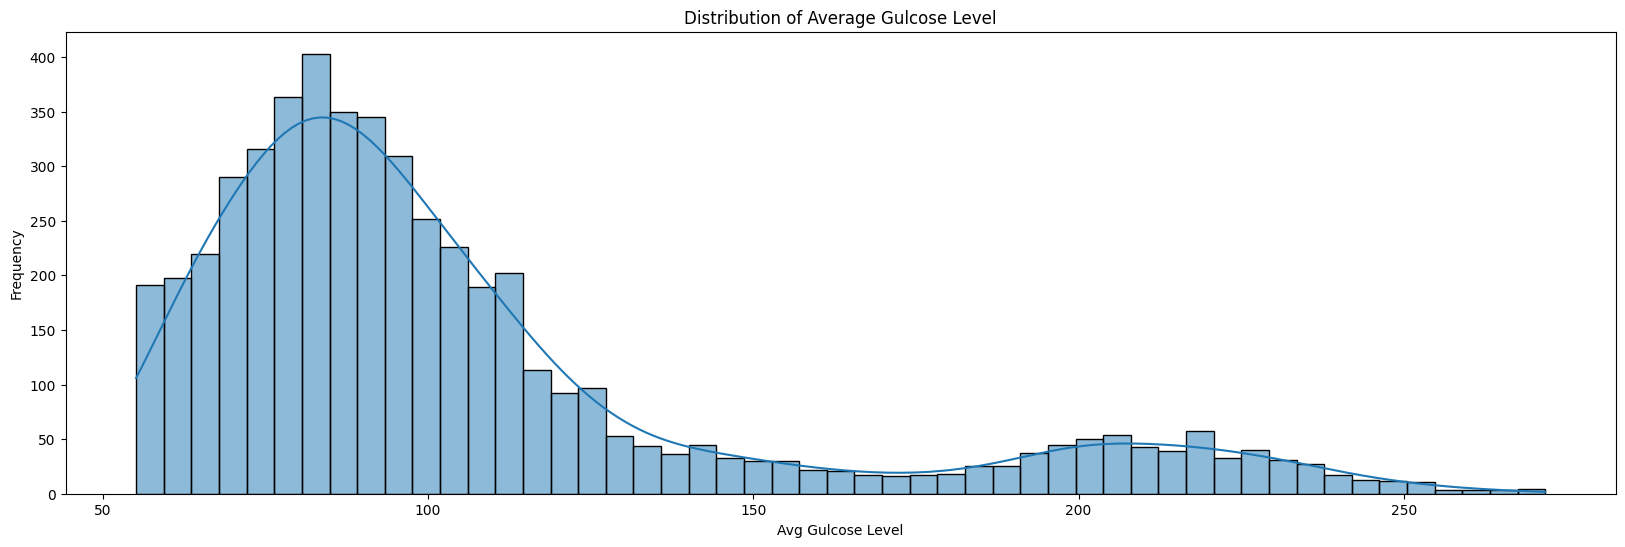

In [19]:
#avg_glucose_level
plt.figure(figsize=(20, 6))
sns.histplot(df['avg_glucose_level'], kde=True)
plt.title('Distribution of Average Gulcose Level')
plt.xlabel('Avg Gulcose Level')
plt.ylabel('Frequency')
plt.show()

In [20]:
print("mean ", df['avg_glucose_level'].mean())
print("median ", df['avg_glucose_level'].median())
print("mode ", df['avg_glucose_level'].mode())

mean  106.1476771037182
median  91.88499999999999
mode  0    93.88
Name: avg_glucose_level, dtype: float64


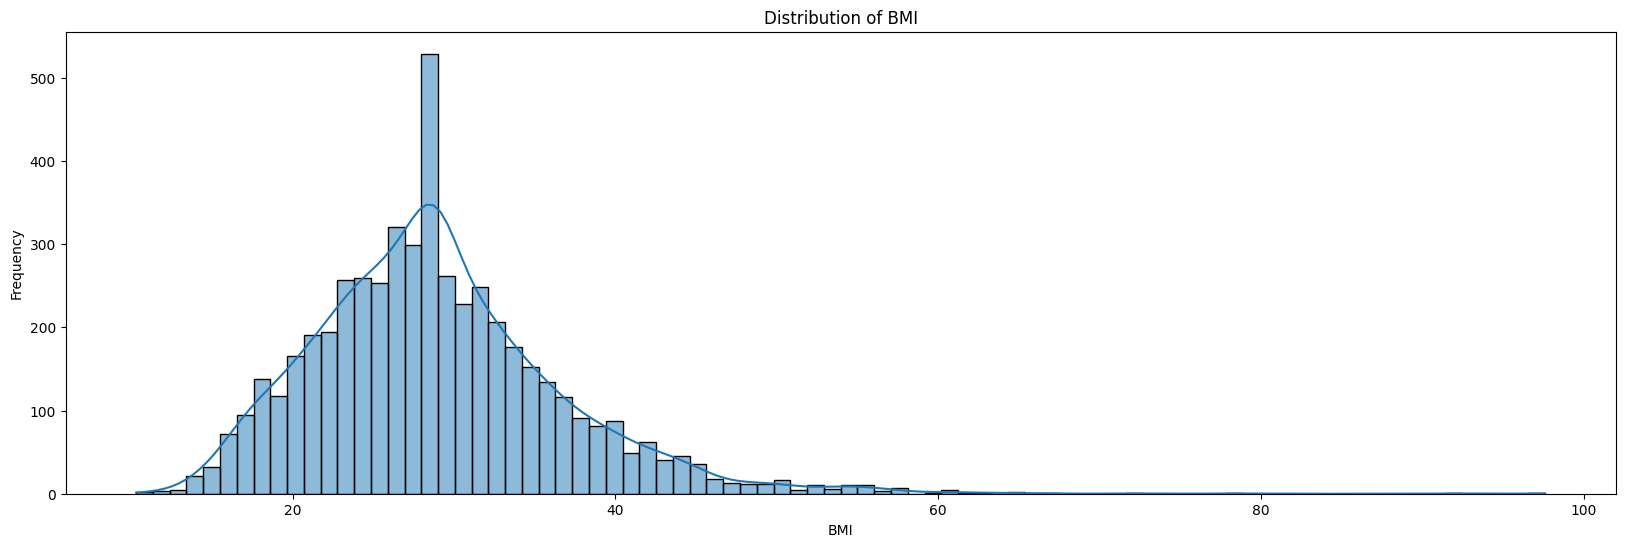

In [21]:
#Histogram
plt.figure(figsize=(20, 6))
sns.histplot(df['bmi'], kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

In [22]:
y = df['stroke']
X = df.drop(columns='stroke')

In [23]:
Counter(y)

Counter({1: 249, 0: 4861})

In [24]:
over = SMOTE(sampling_strategy = 1)
under = RandomUnderSampler(sampling_strategy = 0.1)
steps = [('under', under),('over', over)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
Counter(y)

Counter({0: 2490, 1: 2490})

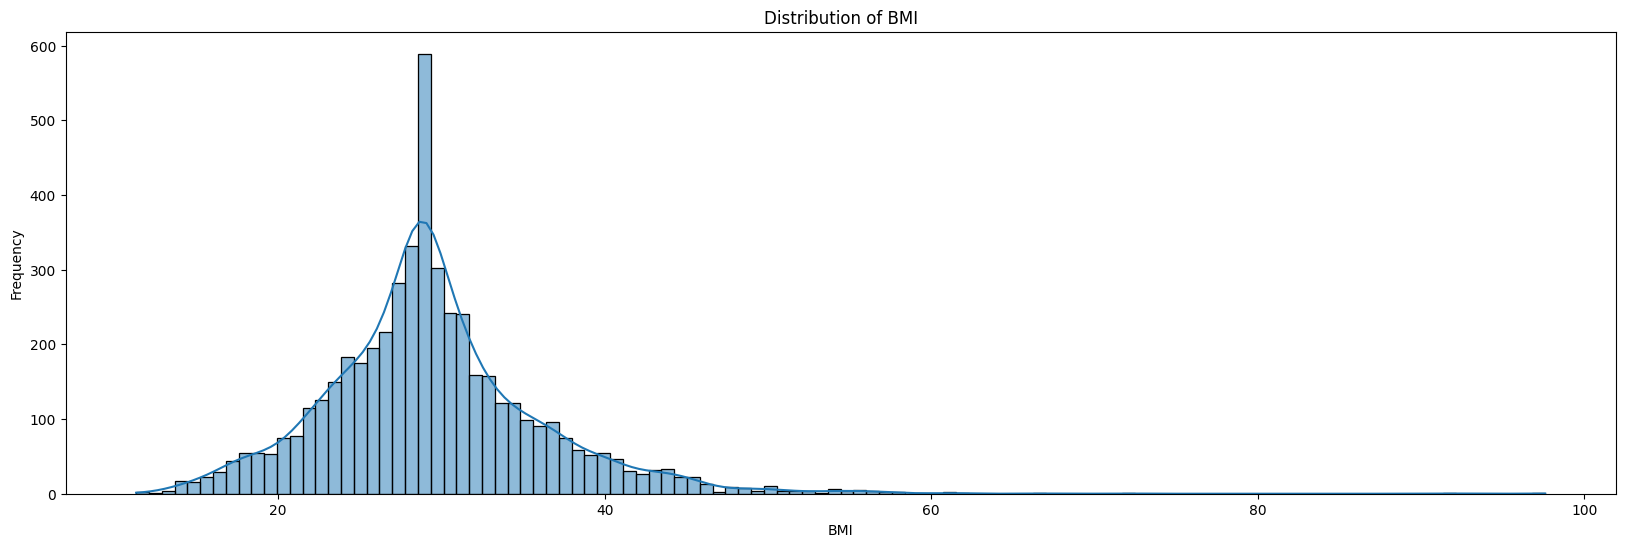

In [25]:
#Histogram
plt.figure(figsize=(20, 6))
sns.histplot(X['bmi'], kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

In [26]:
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,60.000000,0,0,1,2,1,65.780000,27.500000,0
1,1,43.000000,0,0,1,2,0,77.860000,28.900000,2
2,1,53.000000,0,0,0,2,0,65.240000,28.900000,0
3,1,70.000000,1,0,1,2,0,74.040000,29.100000,2
4,1,42.000000,0,0,1,2,1,78.490000,31.800000,3
...,...,...,...,...,...,...,...,...,...,...
4975,0,59.240997,0,0,0,2,0,88.142216,37.521699,1
4976,0,78.999695,0,0,0,2,0,129.980171,22.599237,1
4977,0,80.148362,0,0,0,0,0,71.334740,26.907129,2
4978,0,49.156865,0,0,0,2,0,104.436464,31.821567,3


In [27]:
y

,stroke
0,0
1,0
2,0
3,0
4,0
...,...
4975,1
4976,1
4977,1
4978,1


#XGBoost Model

In [28]:
def xgb_(X, y, num_folds=5):


    print(X.shape)
    print(y.shape)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=24)

    f1_scores = []
    accuracies = []
    precisions = []
    recalls = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold_idx + 1}:")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        xgb1 = xgb.XGBClassifier(
            objective="binary:logistic",
            random_state=42,
        )

        # Fit the model
        xgb1.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

        # Make predictions
        y_pred = xgb1.predict(X_test.to_numpy())

        # Ensure y_test is 1D for comparison
        y_test = y_test.to_numpy().ravel().astype(int)
        y_pred = y_pred.astype(int)

        # Calculate and store F1-score for this fold
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        # Calculate and store accuracy and precision for this fold
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        precision = precision_score(y_test, y_pred, average='weighted')
        precisions.append(precision)
        recall = recall_score(y_test, y_pred, average='weighted')
        recalls.append(recall)

        print(classification_report(y_test, y_pred))
        print(f"Fold {fold_idx + 1} F1-score: {f1:.4f}")
        print(f"Fold {fold_idx + 1} Accuracy: {accuracy:.4f}")
        print(f"Fold {fold_idx + 1} Precision: {precision:.4f}")
        print(f"Fold {fold_idx + 1} Recall: {recall:.4f}")
        # Calculate and print confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)

        print("-" * 30)

    # Calculate and print average metrics across all folds
    avg_f1 = np.mean(f1_scores)
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)

    print(f"Average F1-score across {num_folds} folds: {avg_f1:.4f}")
    print(f"Average Accuracy across {num_folds} folds: {avg_accuracy:.4f}")
    print(f"Average Precision across {num_folds} folds: {avg_precision:.4f}")
    print(f"Average Precision across {num_folds} folds: {avg_recall:.4f}")
    print("\n"*2)
    print(X.shape)
    print(y.shape)
    # Final model: Train on the entire dataset
    print("Training final model on the entire dataset...")


    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)


    final_model = xgb.XGBClassifier(
        objective="binary:logistic",
        random_state=42,
    )

    # Train on the entire dataset
    final_model.fit(X_train_final.to_numpy(), y_train_final.to_numpy().ravel())

    # Evaluate the final model on the test set
    y_pred_final = final_model.predict(X_test_final.to_numpy())

    # Calculate accuracy, precision, confusion matrix for final model
    final_accuracy = accuracy_score(y_test_final, y_pred_final)
    final_precision = precision_score(y_test_final, y_pred_final, average='weighted')
    final_recall = recall_score(y_test_final, y_pred_final, average='weighted')
    final_f1 = f1_score(y_test_final, y_pred_final, average='weighted')
    final_cm = confusion_matrix(y_test_final, y_pred_final)

    print(f"Final Model Accuracy: {final_accuracy:.4f}")
    print(f"Final Model Precision: {final_precision:.4f}")
    print(f"Final Model Recall: {final_recall:.4f}")
    print(f"Final Model F1-score: {final_f1:.4f}")
    print("Final Model Confusion Matrix:")
    print(final_cm)




## Train Test Split vs Cross Fold model

In [29]:
xgb_(X, y)

(4980, 10)
(4980,)
Fold 1:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       502
           1       0.89      0.93      0.91       494

    accuracy                           0.91       996
   macro avg       0.91      0.91      0.91       996
weighted avg       0.91      0.91      0.91       996

Fold 1 F1-score: 0.9066
Fold 1 Accuracy: 0.9066
Fold 1 Precision: 0.9075
Fold 1 Recall: 0.9066
Confusion Matrix:
[[444  58]
 [ 35 459]]
------------------------------
Fold 2:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       488
           1       0.90      0.91      0.91       508

    accuracy                           0.91       996
   macro avg       0.91      0.91      0.91       996
weighted avg       0.91      0.91      0.91       996

Fold 2 F1-score: 0.9056
Fold 2 Accuracy: 0.9056
Fold 2 Precision: 0.9057
Fold 2 Recall: 0.9056
Confusion Matrix:
[[438  50]
 [ 44 464]]
--------

# Training the model with whole Dataset and Testing with half of the dataset



In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=24)
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Download the file
from google.colab import files
files.download('xgb_model.pkl')

Accuracy: 0.9963855421686747
Precision: 0.9963884104158569
Recall: 0.9963855421686747
F1-score: 0.996385529926257
Confusion Matrix:
[[1237    6]
 [   3 1244]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Testing the model with only Stroke dataset (Where stroke==1)

In [31]:
#Testing all rows where stroke == 1


y_pred = model.predict(df_stroke.drop(columns='stroke'))

# Evaluate the model
accuracy = accuracy_score(df_stroke['stroke'], y_pred)
precision = precision_score(df_stroke['stroke'], y_pred, average='weighted')
recall = recall_score(df_stroke['stroke'], y_pred, average='weighted')
f1 = f1_score(df_stroke['stroke'], y_pred, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
cm = confusion_matrix(df_stroke['stroke'], y_pred)
print("Confusion Matrix:")
print(cm)



Accuracy: 0.9919678714859438
Precision: 1.0
Recall: 0.9919678714859438
F1-score: 0.9959677419354839
Confusion Matrix:
[[  0   0]
 [  2 247]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#SVM model

In [32]:
def svm_(x,y,num_folds=5):
    print(X.shape)
    print(y.shape)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=24)

    f1_scores = []
    accuracies = []
    precisions = []
    recalls = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold_idx + 1}:")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = svm.SVC(random_state=42)

            # Fit the model
        model.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

        # Make predictions
        y_pred = model.predict(X_test.to_numpy())

        # Ensure y_test is 1D for comparison
        y_test = y_test.to_numpy().ravel().astype(int)
        y_pred = y_pred.astype(int)

        # Calculate and store F1-score for this fold
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        # Calculate and store accuracy and precision for this fold
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        precision = precision_score(y_test, y_pred, average='weighted')
        precisions.append(precision)
        recall = recall_score(y_test, y_pred, average='weighted')
        recalls.append(recall)
        print(classification_report(y_test, y_pred))
        print(f"Fold {fold_idx + 1} F1-score: {f1:.4f}")
        print(f"Fold {fold_idx + 1} Accuracy: {accuracy:.4f}")
        print(f"Fold {fold_idx + 1} Precision: {precision:.4f}")
        print(f"Fold {fold_idx + 1} Recall: {recall:.4f}")
        # Calculate and print confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)

        print("-" * 30)



    # Calculate and print average metrics across all folds
    avg_f1 = np.mean(f1_scores)
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)

    print(f"Average F1-score across {num_folds} folds: {avg_f1:.4f}")
    print(f"Average Accuracy across {num_folds} folds: {avg_accuracy:.4f}")
    print(f"Average Precision across {num_folds} folds: {avg_precision:.4f}")
    print(f"Average Recall across {num_folds} folds: {avg_recall:.4f}")

    print("\n"*2)
    print(X.shape)
    print(y.shape)
    # Final model: Train on the entire dataset
    print("Training final model on the entire dataset...")


    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

    # Final model
    final_model = svm.SVC(random_state=42)


    # Train on the entire dataset
    final_model.fit(X_train_final.to_numpy(), y_train_final.to_numpy().ravel())

    # Evaluate the final model on the test set
    y_pred_final = final_model.predict(X_test_final.to_numpy())

    # Calculate accuracy, precision, confusion matrix for final model
    final_accuracy = accuracy_score(y_test_final, y_pred_final)
    final_precision = precision_score(y_test_final, y_pred_final, average='weighted')
    final_recall = recall_score(y_test_final, y_pred_final, average='weighted')
    final_f1 = f1_score(y_test_final, y_pred_final, average='weighted')
    final_cm = confusion_matrix(y_test_final, y_pred_final)

    print(f"Final Model Accuracy: {final_accuracy:.4f}")
    print(f"Final Model Precision: {final_precision:.4f}")
    print(f"Final Model Recall: {final_recall:.4f}")
    print(f"Final Model F1-score: {final_f1:.4f}")
    print("Final Model Confusion Matrix:")
    print(final_cm)



In [33]:
svm_(X,y)

(4980, 10)
(4980,)
Fold 1:
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       502
           1       0.72      0.84      0.77       494

    accuracy                           0.76       996
   macro avg       0.76      0.76      0.76       996
weighted avg       0.77      0.76      0.76       996

Fold 1 F1-score: 0.7566
Fold 1 Accuracy: 0.7580
Fold 1 Precision: 0.7653
Fold 1 Recall: 0.7580
Confusion Matrix:
[[341 161]
 [ 80 414]]
------------------------------
Fold 2:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       488
           1       0.73      0.80      0.76       508

    accuracy                           0.75       996
   macro avg       0.75      0.75      0.75       996
weighted avg       0.75      0.75      0.75       996

Fold 2 F1-score: 0.7483
Fold 2 Accuracy: 0.7490
Fold 2 Precision: 0.7505
Fold 2 Recall: 0.7490
Confusion Matrix:
[[341 147]
 [103 405]]
--------

In [34]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,28.893237,2,0
5106,0,81.0,0,0,1,3,1,125.20,40.000000,2,0
5107,0,35.0,0,0,1,3,0,82.99,30.600000,2,0
5108,1,51.0,0,0,1,2,0,166.29,25.600000,1,0


In [35]:
y

,stroke
0,0
1,0
2,0
3,0
4,0
...,...
4975,1
4976,1
4977,1
4978,1


In [36]:
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,60.000000,0,0,1,2,1,65.780000,27.500000,0
1,1,43.000000,0,0,1,2,0,77.860000,28.900000,2
2,1,53.000000,0,0,0,2,0,65.240000,28.900000,0
3,1,70.000000,1,0,1,2,0,74.040000,29.100000,2
4,1,42.000000,0,0,1,2,1,78.490000,31.800000,3
...,...,...,...,...,...,...,...,...,...,...
4975,0,59.240997,0,0,0,2,0,88.142216,37.521699,1
4976,0,78.999695,0,0,0,2,0,129.980171,22.599237,1
4977,0,80.148362,0,0,0,0,0,71.334740,26.907129,2
4978,0,49.156865,0,0,0,2,0,104.436464,31.821567,3


In [37]:

# # Generate labels for the new data
# new_data['predicted_labels'] = model.predict(new_data)

In [38]:
# y_pred = imported_model.predict(df_stroke.drop(columns='stroke'))

# # Evaluate the model
# accuracy = accuracy_score(df_stroke['stroke'], y_pred)
# print(f"Accuracy: {accuracy}")

# cm = confusion_matrix(df_stroke['stroke'], y_pred)
# print("Confusion Matrix:")
# print(cm)


In [39]:
df_stroke.drop(columns='stroke')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,1,1,228.69,36.600000,1
1,0,61.0,0,0,1,2,0,202.21,28.893237,2
2,1,80.0,0,1,1,1,0,105.92,32.500000,2
3,0,49.0,0,0,1,1,1,171.23,34.400000,3
4,0,79.0,1,0,1,2,0,174.12,24.000000,2
...,...,...,...,...,...,...,...,...,...,...
244,1,57.0,0,0,1,1,0,84.96,36.700000,0
245,0,14.0,0,0,0,3,0,57.93,30.900000,0
246,0,75.0,0,0,1,2,0,78.80,29.300000,1
247,1,71.0,1,0,1,2,0,87.80,28.893237,0


## Manually testing the uploaded model

In [40]:
with open("stroke_xgb_model.pkl", "rb") as file:
    imported_model = pickle.load(file)

#FOR stroke = 0
x_values = np.array([[
    0, 38.000000, 0, 0, 1, 2, 0, 66.160000, 42.700000, 0
]])
print(imported_model.predict(x_values))


#FOR stroke = 0
x_values_2 = np.array([[
    0, 76.000000, 0, 0,	1, 2, 1, 183.340000, 39.500000, 1
]])
print(imported_model.predict(x_values_2))


#FOR stroke = 1
x_values_3 = np.array([[
    1,	67.0,	0,	1,	1,	1,	1,	228.69,	36.600000,	1
    ]])
print(imported_model.predict(x_values_3))

#FOR stroke = 1
x_values_4 = np.array([[
    0,	61.0,	0, 0,	1, 2,	0, 202.21, 28.893237, 2
    ]])
print(imported_model.predict(x_values_4))

[0]
[0]
[1]
[1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:01:34] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


<ipython-input-41-79c6174e7baa>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_stroke, x='gender', palette=['pink', 'skyblue'])


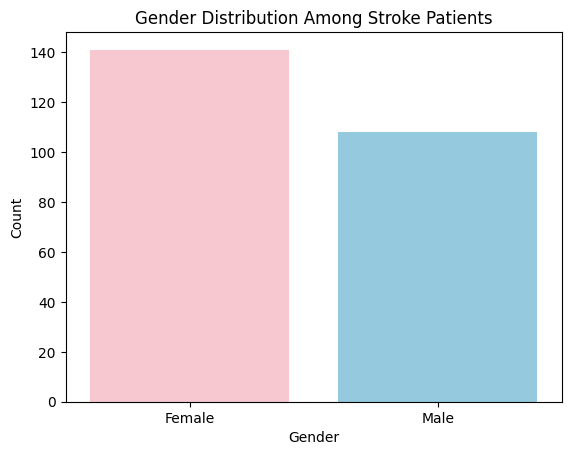

There are 13.25% more males than females who got a stroke.


In [41]:
sns.countplot(data=df_stroke, x='gender', palette=['pink', 'skyblue'])
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'])
plt.title("Gender Distribution Among Stroke Patients")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

total_females_stroke = df_stroke[df_stroke['gender'] == 1].shape[0]
total_males_stroke = df_stroke[df_stroke['gender'] == 0].shape[0]
total_people_stroke = df_stroke.shape[0]
percent_females_stroke = (total_females_stroke / total_people_stroke) * 100
percent_males_stroke = (total_males_stroke / total_people_stroke) * 100
percentage_diff = percent_females_stroke - percent_males_stroke


if percentage_diff > 0:
    print(f"There are {percentage_diff:.2f}% more females than males who got a stroke.")
else:
    print(f"There are {abs(percentage_diff):.2f}% more males than females who got a stroke.")

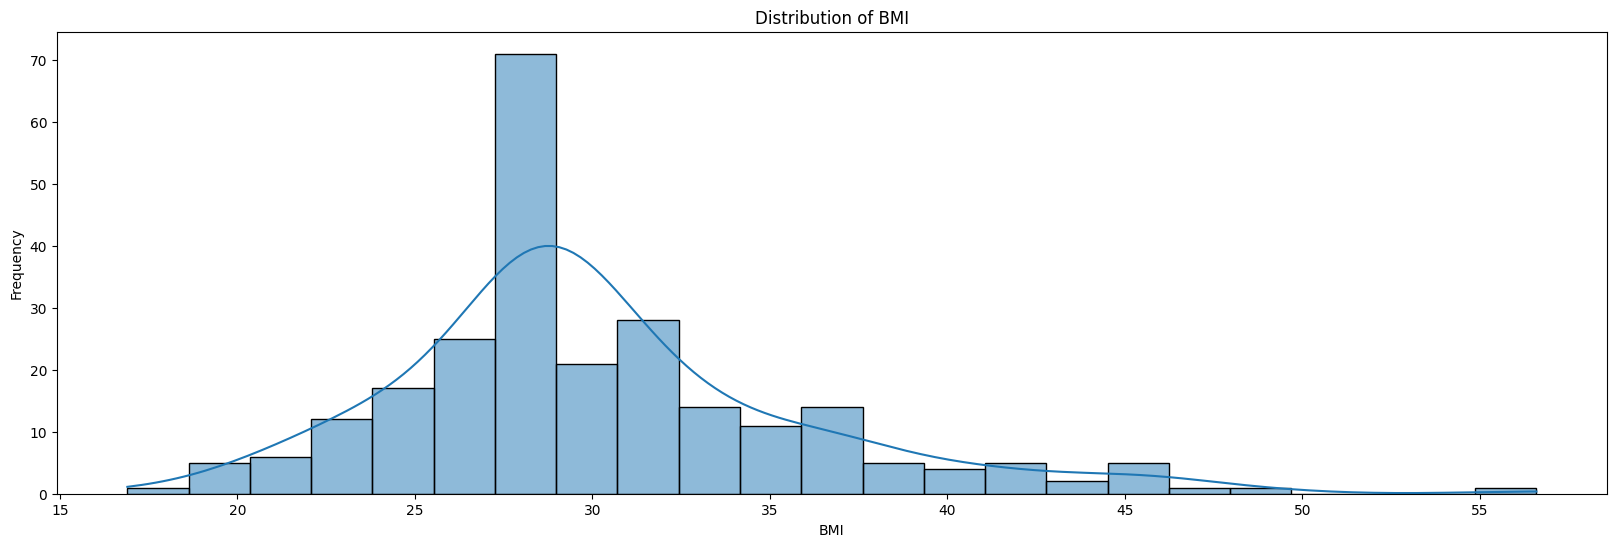

Average BMI of people who had stroke is :30.22


In [42]:
#Histogram
plt.figure(figsize=(20, 6))
sns.histplot(df_stroke['bmi'], kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

print(f"Average BMI of people who had stroke is :{(df_stroke['bmi'].mean()):.2f}")

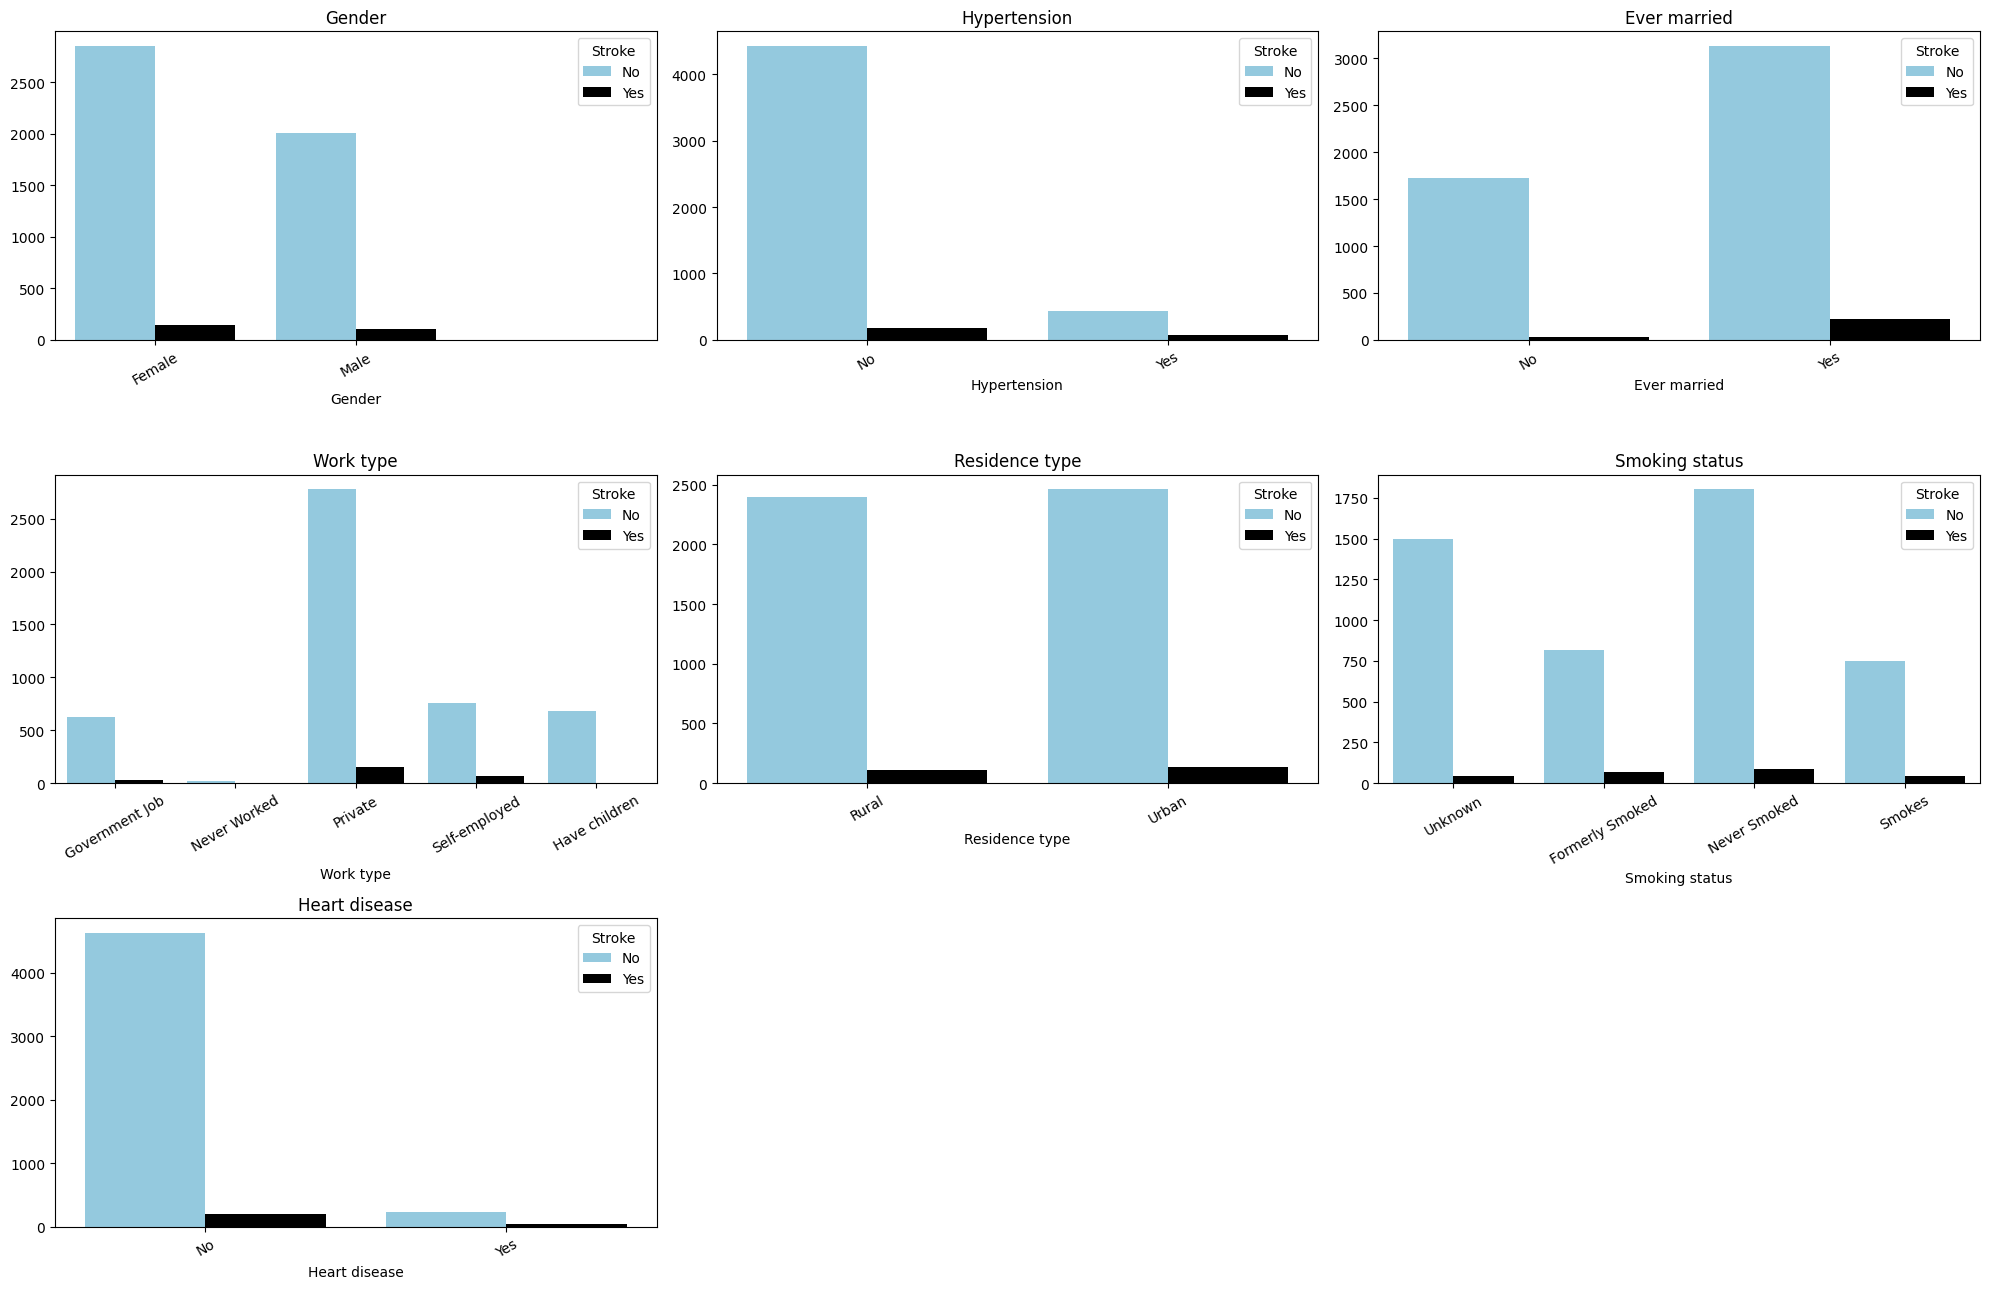

In [43]:
columns = ['gender', 'hypertension', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'heart_disease']
label_mappings = {
    'gender': ['Female', 'Male'],
    'hypertension': ['No', 'Yes'],
    'ever_married': ['No', 'Yes'],
    'work_type': ['Government Job', 'Never Worked', 'Private', 'Self-employed', 'Have children'],
    'Residence_type': ['Rural', 'Urban'],
    'smoking_status': ['Unknown', 'Formerly Smoked', 'Never Smoked', 'Smokes'],
    'heart_disease': ['No', 'Yes']
}

plt.figure(figsize=(20, 13))
for col in range(len(columns)):
    plt.subplot(3, 3, col + 1)
    sns.countplot(x=df[columns[col]], hue=df['stroke'], palette=['skyblue', 'black'])
    plt.title(columns[col].replace('_', ' ').capitalize())
    plt.xticks(
        ticks=range(len(label_mappings[columns[col]])),
        labels=label_mappings[columns[col]],
        rotation=30
    )
    plt.xlabel(columns[col].replace('_', ' ').capitalize())
    plt.legend(title="Stroke", labels=['No', 'Yes'])
    plt.ylabel('')

plt.tight_layout()
plt.show()


## Analysis on People who had stroke

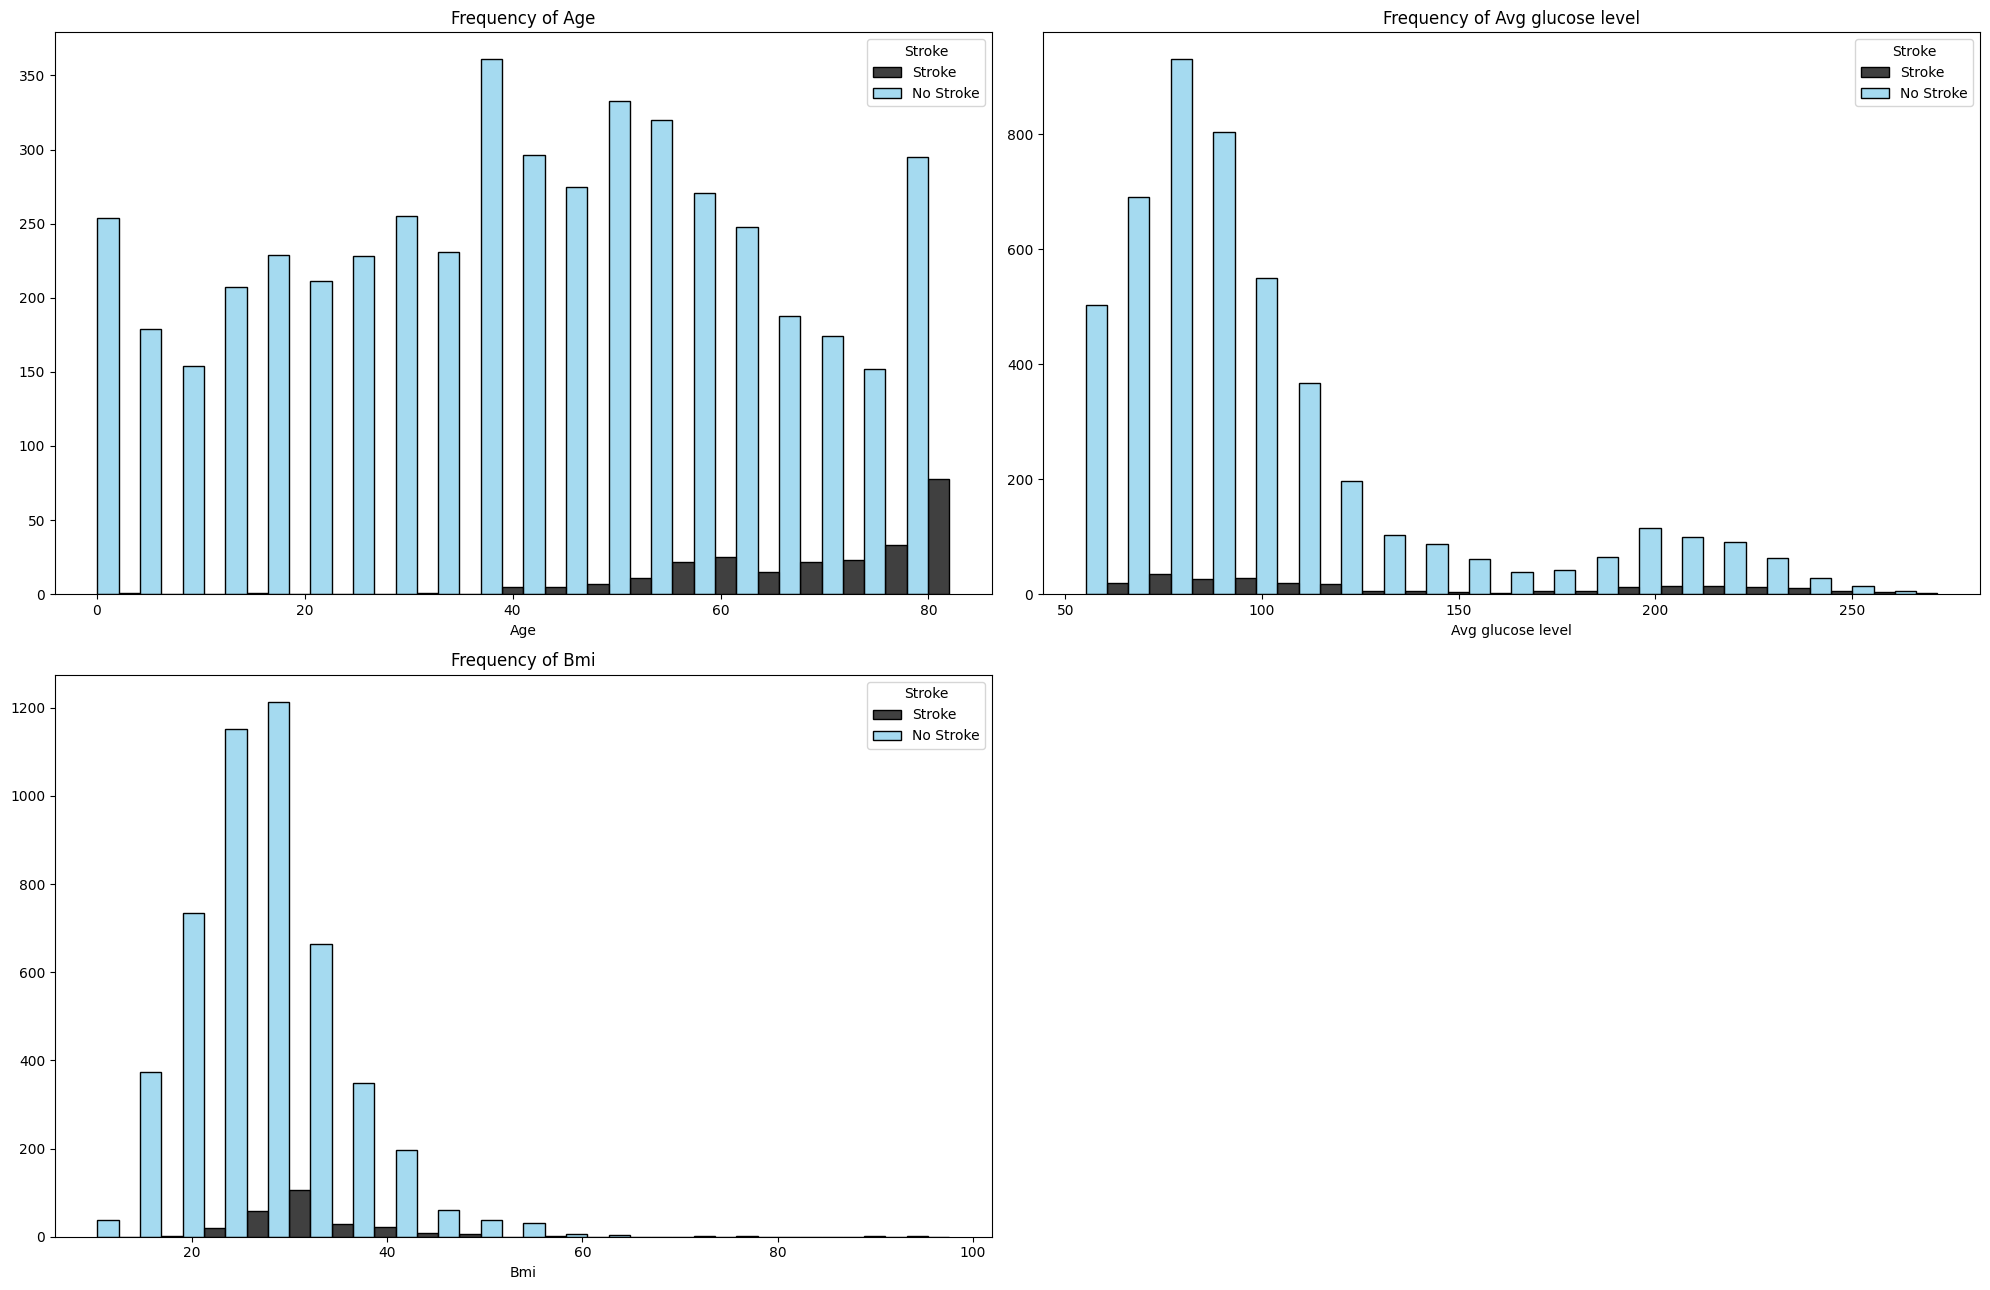

In [44]:
# Continuous variables to compare
continuous_columns = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(20, 13))
for i, col in enumerate(continuous_columns):
    plt.subplot(2, 2, i + 1)

    # Histogram for distribution comparison
    sns.histplot(data=df, x=col, hue='stroke', kde=False, palette=['skyblue', 'black'], bins=20, multiple='dodge')

    # Set plot details
    plt.title(f"Frequency of {col.replace('_', ' ').capitalize()}")
    plt.xlabel(col.replace('_', ' ').capitalize())
    plt.ylabel('')
    plt.legend(title='Stroke', labels=['Stroke', 'No Stroke'])

plt.tight_layout()
plt.show()


In [45]:
total_people_stroke = df_stroke.shape[0]

# Gender
stroke_females = df_stroke[df_stroke['gender'] == 0].shape[0]
stroke_males = df_stroke[df_stroke['gender'] == 1].shape[0]

percent_females_stroke = (stroke_females / total_people_stroke) * 100
percent_males_stroke = (stroke_males / total_people_stroke) * 100

print(f"Gender-wise stroke distribution: {percent_females_stroke:.2f}% Female, {percent_males_stroke:.2f}% Male")

# Hypertension
stroke_no_hypertension = df_stroke[df_stroke['hypertension'] == 0].shape[0]
stroke_with_hypertension = df_stroke[df_stroke['hypertension'] == 1].shape[0]

percent_no_hypertension = (stroke_no_hypertension / total_people_stroke) * 100
percent_with_hypertension = (stroke_with_hypertension / total_people_stroke) * 100

print(f"Hypertension-wise stroke distribution: {percent_no_hypertension:.2f}% No Hypertension, {percent_with_hypertension:.2f}% With Hypertension")

# Ever Married
stroke_never_married = df_stroke[df_stroke['ever_married'] == 0].shape[0]
stroke_married = df_stroke[df_stroke['ever_married'] == 1].shape[0]

percent_never_married = (stroke_never_married / total_people_stroke) * 100
percent_married = (stroke_married / total_people_stroke) * 100

print(f"Marital status stroke distribution: {percent_never_married:.2f}% Never Married, {percent_married:.2f}% Married")

# Work Type
work_labels = ['Government Job', 'Never Worked', 'Private', 'Self-employed', 'Have children']
work_counts = [df_stroke[df_stroke['work_type'] == i].shape[0] for i in range(5)]
work_percentages = [(count / total_people_stroke) * 100 for count in work_counts]

print("Work type stroke distribution:")
for label, percent in zip(work_labels, work_percentages):
    print(f"  {label}: {percent:.2f}%")

# Residence Type
stroke_rural = df_stroke[df_stroke['Residence_type'] == 0].shape[0]
stroke_urban = df_stroke[df_stroke['Residence_type'] == 1].shape[0]

percent_rural = (stroke_rural / total_people_stroke) * 100
percent_urban = (stroke_urban / total_people_stroke) * 100

print(f"Residence type stroke distribution: {percent_rural:.2f}% Rural, {percent_urban:.2f}% Urban")

# Smoking Status
smoking_labels = ['Unknown', 'Formerly Smoked', 'Never Smoked', 'Smokes']
smoking_counts = [df_stroke[df_stroke['smoking_status'] == i].shape[0] for i in range(4)]
smoking_percentages = [(count / total_people_stroke) * 100 for count in smoking_counts]

print("Smoking status stroke distribution:")
for label, percent in zip(smoking_labels, smoking_percentages):
    print(f"  {label}: {percent:.2f}%")

# Heart Disease
stroke_no_heart_disease = df_stroke[df_stroke['heart_disease'] == 0].shape[0]
stroke_with_heart_disease = df_stroke[df_stroke['heart_disease'] == 1].shape[0]

percent_no_heart_disease = (stroke_no_heart_disease / total_people_stroke) * 100
percent_with_heart_disease = (stroke_with_heart_disease / total_people_stroke) * 100

print(f"Heart disease stroke distribution: {percent_no_heart_disease:.2f}% No Heart Disease, {percent_with_heart_disease:.2f}% With Heart Disease")


print("Average BMI",df_stroke['bmi'].mean())
print("Average age",df_stroke['age'].mean())
print("Average Gulcose Level",df_stroke['avg_glucose_level'].mean())

Gender-wise stroke distribution: 56.63% Female, 43.37% Male
Hypertension-wise stroke distribution: 73.49% No Hypertension, 26.51% With Hypertension
Marital status stroke distribution: 11.65% Never Married, 88.35% Married
Work type stroke distribution:
  Government Job: 13.25%
  Never Worked: 59.84%
  Private: 26.10%
  Self-employed: 0.80%
  Have children: 0.00%
Residence type stroke distribution: 45.78% Rural, 54.22% Urban
Smoking status stroke distribution:
  Unknown: 18.88%
  Formerly Smoked: 28.11%
  Never Smoked: 36.14%
  Smokes: 16.87%
Heart disease stroke distribution: 81.12% No Heart Disease, 18.88% With Heart Disease
Average BMI 30.217789062135687
Average age 67.72819277108434
Average Gulcose Level 132.54473895582328


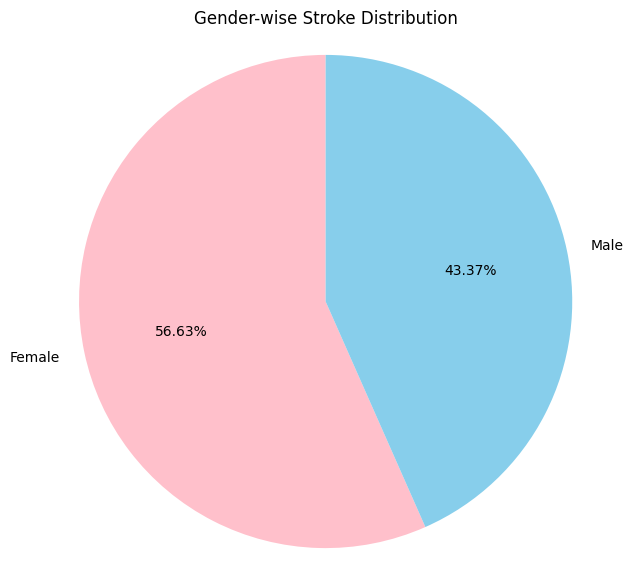

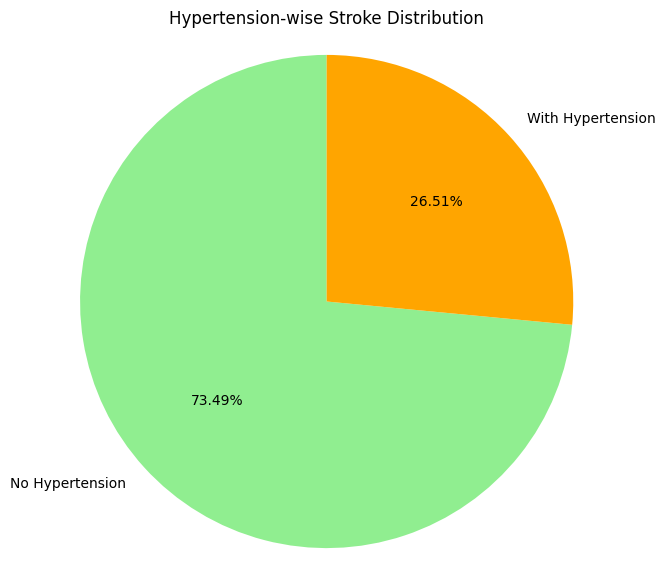

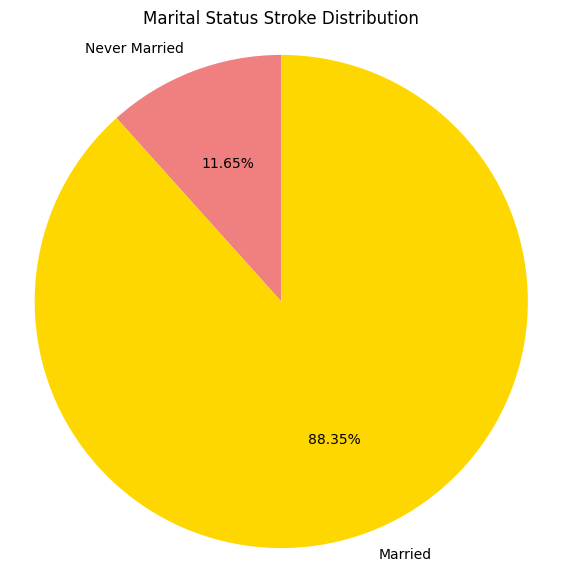

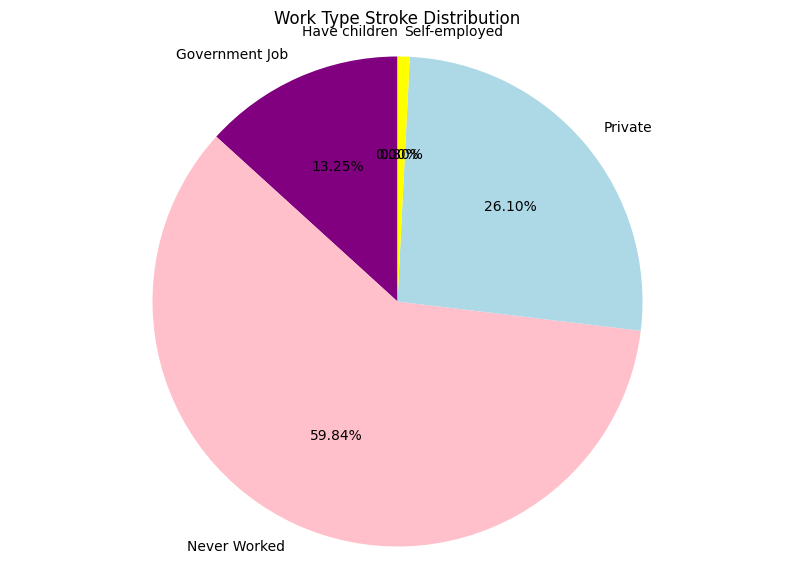

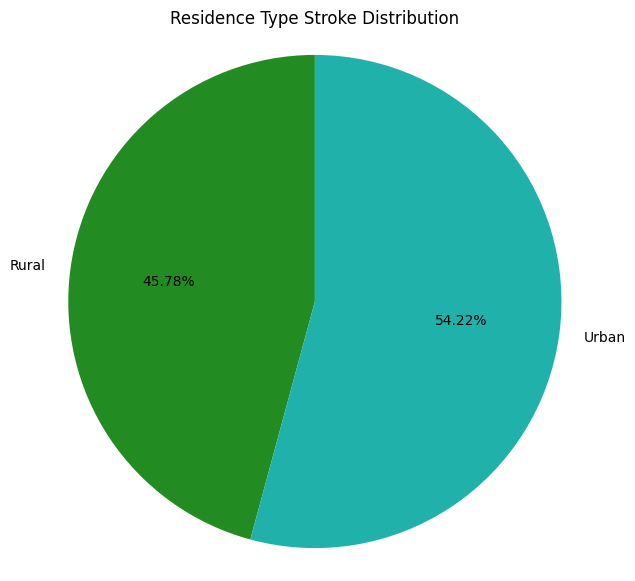

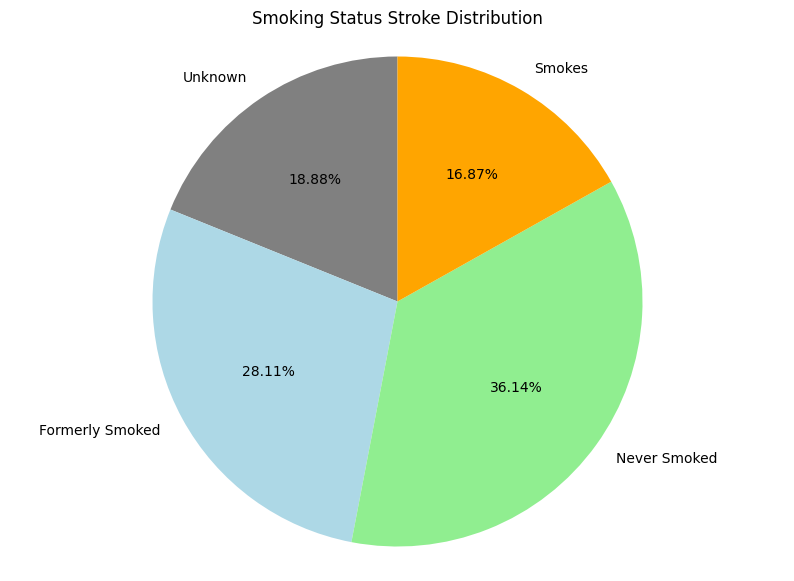

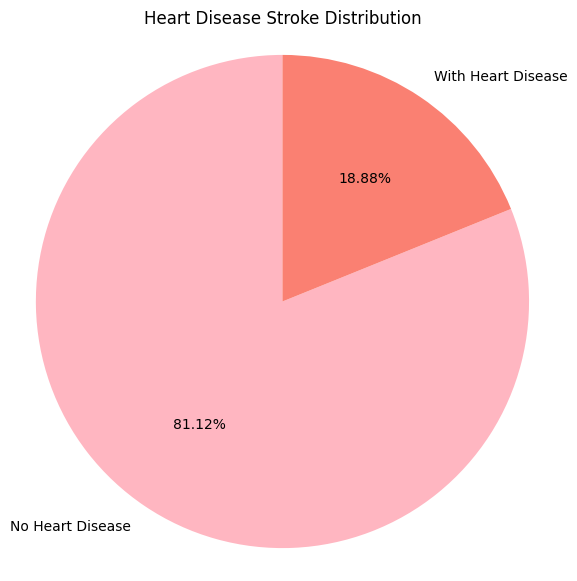

In [46]:

# Gender Pie Chart
gender_labels = ['Female', 'Male']
gender_sizes = [percent_females_stroke, percent_males_stroke]
plt.figure(figsize=(7, 7))
plt.pie(gender_sizes, labels=gender_labels, autopct='%1.2f%%', colors=['pink', 'skyblue'], startangle=90)
plt.title("Gender-wise Stroke Distribution")
plt.axis('equal')
plt.show()

# Hypertension Pie Chart
hypertension_labels = ['No Hypertension', 'With Hypertension']
hypertension_sizes = [percent_no_hypertension, percent_with_hypertension]
plt.figure(figsize=(7, 7))
plt.pie(hypertension_sizes, labels=hypertension_labels, autopct='%1.2f%%', colors=['lightgreen', 'orange'], startangle=90)
plt.title("Hypertension-wise Stroke Distribution")
plt.axis('equal')
plt.show()

# Marital Status Pie Chart
marital_labels = ['Never Married', 'Married']
marital_sizes = [percent_never_married, percent_married]
plt.figure(figsize=(7, 7))
plt.pie(marital_sizes, labels=marital_labels, autopct='%1.2f%%', colors=['lightcoral', 'gold'], startangle=90)
plt.title("Marital Status Stroke Distribution")
plt.axis('equal')
plt.show()

# Work Type Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(work_percentages, labels=work_labels, autopct='%1.2f%%', startangle=90, colors=['purple', 'pink', 'lightblue', 'yellow', 'green'])
plt.title("Work Type Stroke Distribution")
plt.axis('equal')
plt.show()

# Residence Type Pie Chart
residence_labels = ['Rural', 'Urban']
residence_sizes = [percent_rural, percent_urban]
plt.figure(figsize=(7, 7))
plt.pie(residence_sizes, labels=residence_labels, autopct='%1.2f%%', colors=['forestgreen', 'lightseagreen'], startangle=90)
plt.title("Residence Type Stroke Distribution")
plt.axis('equal')
plt.show()

# Smoking Status Pie Chart
smoking_labels = ['Unknown', 'Formerly Smoked', 'Never Smoked', 'Smokes']
smoking_sizes = smoking_percentages
plt.figure(figsize=(10, 7))
plt.pie(smoking_sizes, labels=smoking_labels, autopct='%1.2f%%', startangle=90, colors=['gray', 'lightblue', 'lightgreen', 'orange'])
plt.title("Smoking Status Stroke Distribution")
plt.axis('equal')
plt.show()

# Heart Disease Pie Chart
heart_disease_labels = ['No Heart Disease', 'With Heart Disease']
heart_disease_sizes = [percent_no_heart_disease, percent_with_heart_disease]
plt.figure(figsize=(7, 7))
plt.pie(heart_disease_sizes, labels=heart_disease_labels, autopct='%1.2f%%', colors=['lightpink', 'salmon'], startangle=90)
plt.title("Heart Disease Stroke Distribution")
plt.axis('equal')
plt.show()

# Analysis With Fake Data

In [47]:
#random.choice(gender_mapping)

In [48]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,28.893237,2,0
5106,0,81.0,0,0,1,3,1,125.20,40.000000,2,0
5107,0,35.0,0,0,1,3,0,82.99,30.600000,2,0
5108,1,51.0,0,0,1,2,0,166.29,25.600000,1,0


In [49]:
random_age = []
random_hypertension = []
random_ever_married = []
random_work_type = []
random_residence_type = []
random_avg_glucose_level = []
random_bmi = []
random_smoking_status = []
random_heart_disease = []
random_gender = []
random_stroke = []


for i in range(1000):
  random_age.append(random.choice(original['age']))
  random_hypertension.append(random.choice(original['hypertension']))
  random_ever_married.append(random.choice(original['ever_married']))
  random_work_type.append(random.choice(original['work_type']))
  random_residence_type.append(random.choice(original['Residence_type']))
  random_avg_glucose_level.append(random.choice(original['avg_glucose_level']))
  random_bmi.append(random.choice(original['bmi']))
  random_smoking_status.append(random.choice(original['smoking_status']))
  random_heart_disease.append(random.choice(original['heart_disease']))
  random_gender.append(random.choice(original['gender']))
  random_stroke.append(random.choice(original['stroke']))

fake_data = {
    "age": random_age,
    "hypertension": random_hypertension,
    "ever_married": random_ever_married,
    "work_type": random_work_type,
    "Residence_type": random_residence_type,
    "avg_glucose_level": random_avg_glucose_level,
    "bmi": random_bmi,
    "smoking_status": random_smoking_status,
    "heart_disease": random_heart_disease,
    "gender": random_gender,
    "stroke": random_stroke
}

df_fakedata = pd.DataFrame(fake_data)


# df_fakedata['age']= pd.concat([df_fakedata['age'], pd.Series(random_age)], ignore_index=True)
# df_fakedata['hypertension']= pd.concat([df_fakedata['hypertension'], pd.Series(random_hypertension)], ignore_index=True)
# df_fakedata['ever_married']= pd.concat([df_fakedata['ever_married'], pd.Series(random_ever_married)], ignore_index=True)
# df_fakedata['work_type']= pd.concat([df_fakedata['work_type'], pd.Series(random_work_type)], ignore_index=True)
# df_fakedata['Residence_type']= pd.concat([df_fakedata['Residence_type'], pd.Series(random_residence_type)], ignore_index=True)
# df_fakedata['avg_glucose_level']= pd.concat([df_fakedata['avg_glucose_level'], pd.Series(random_avg_glucose_level)], ignore_index=True)
# df_fakedata['bmi']= pd.concat([df_fakedata['bmi'], pd.Series(random_bmi)], ignore_index=True)
# df_fakedata['smoking_status']= pd.concat([df_fakedata['smoking_status'], pd.Series(random_smoking_status)], ignore_index=True)
# df_fakedata['heart_disease']= pd.concat([df_fakedata['heart_disease'], pd.Series(random_heart_disease)], ignore_index=True)
# df_fakedata['gender']= pd.concat([df_fakedata['gender'], pd.Series(random_gender)], ignore_index=True)
# df_fakedata['stroke']= pd.concat([df_fakedata['stroke'], pd.Series(random_stroke)], ignore_index=True)


In [50]:
df_mix = pd.concat([original, df_fakedata], ignore_index=True)

In [51]:
df_mix

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...
6105,0,78.0,0,0,0,0,1,115.13,25.000000,0,1
6106,1,74.0,0,0,0,2,0,101.24,28.500000,0,0
6107,0,26.0,0,0,1,2,1,103.21,31.100000,2,0
6108,0,60.0,0,0,0,2,1,85.08,18.800000,2,0


In [52]:
xgb_(df_mix.drop(columns='stroke'),df_mix['stroke'])

(6110, 10)
(6110,)
Fold 1:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1166
           1       0.00      0.00      0.00        56

    accuracy                           0.94      1222
   macro avg       0.48      0.49      0.49      1222
weighted avg       0.91      0.94      0.93      1222

Fold 1 F1-score: 0.9269
Fold 1 Accuracy: 0.9444
Fold 1 Precision: 0.9100
Fold 1 Recall: 0.9444
Confusion Matrix:
[[1154   12]
 [  56    0]]
------------------------------
Fold 2:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1177
           1       0.17      0.04      0.07        45

    accuracy                           0.96      1222
   macro avg       0.57      0.52      0.52      1222
weighted avg       0.94      0.96      0.94      1222

Fold 2 F1-score: 0.9444
Fold 2 Accuracy: 0.9566
Fold 2 Precision: 0.9351
Fold 2 Recall: 0.9566
Confusion Matrix:
[[1167   10]
 [  43    2]]


In [53]:
y = df_mix['stroke']
X = df_mix.drop(columns='stroke')

In [54]:
Counter(y)

Counter({1: 290, 0: 5820})

In [55]:
over = SMOTE(sampling_strategy = 1)
under = RandomUnderSampler(sampling_strategy = 0.1)
steps = [('under', under),('over', over)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
Counter(y)

Counter({0: 2900, 1: 2900})

In [56]:
svm_(X,y)

(5800, 10)
(5800,)
Fold 1:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       587
           1       0.72      0.71      0.71       573

    accuracy                           0.72      1160
   macro avg       0.72      0.72      0.72      1160
weighted avg       0.72      0.72      0.72      1160

Fold 1 F1-score: 0.7189
Fold 1 Accuracy: 0.7190
Fold 1 Precision: 0.7190
Fold 1 Recall: 0.7190
Confusion Matrix:
[[427 160]
 [166 407]]
------------------------------
Fold 2:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       590
           1       0.73      0.71      0.72       570

    accuracy                           0.73      1160
   macro avg       0.73      0.73      0.73      1160
weighted avg       0.73      0.73      0.73      1160

Fold 2 F1-score: 0.7283
Fold 2 Accuracy: 0.7284
Fold 2 Precision: 0.7285
Fold 2 Recall: 0.7284
Confusion Matrix:
[[440 150]
 [165 405]]
--------

In [57]:
original_df = original
mix_df = df_mix
def calculate_percentage_distribution(df, column):
    return df[column].value_counts(normalize=True) * 100
for column in original_df.columns:
    if original_df[column].dtype == 'object' or original_df[column].nunique() < 10:  # Compare categorical or low-cardinality columns
        original_dist = calculate_percentage_distribution(original_df, column)
        mix_dist = calculate_percentage_distribution(mix_df, column)

        print(f"Column: {column}")
        for value in original_dist.index:
            original_percent = original_dist[value]
            mix_percent = mix_dist.get(value, 0)  # Use 0 if value not present in mix_df
            print(f"  {value}: Original_df = {original_percent:.2f}%, Mix_df = {mix_percent:.2f}%")
        print()

Column: gender
  0: Original_df = 58.59%, Mix_df = 58.63%
  1: Original_df = 41.39%, Mix_df = 41.36%
  2: Original_df = 0.02%, Mix_df = 0.02%

Column: hypertension
  0: Original_df = 90.25%, Mix_df = 90.18%
  1: Original_df = 9.75%, Mix_df = 9.82%

Column: heart_disease
  0: Original_df = 94.60%, Mix_df = 94.40%
  1: Original_df = 5.40%, Mix_df = 5.60%

Column: ever_married
  1: Original_df = 65.62%, Mix_df = 65.58%
  0: Original_df = 34.38%, Mix_df = 34.42%

Column: work_type
  2: Original_df = 57.24%, Mix_df = 57.35%
  3: Original_df = 16.03%, Mix_df = 15.83%
  4: Original_df = 13.44%, Mix_df = 13.44%
  0: Original_df = 12.86%, Mix_df = 12.93%
  1: Original_df = 0.43%, Mix_df = 0.46%

Column: Residence_type
  1: Original_df = 50.80%, Mix_df = 50.79%
  0: Original_df = 49.20%, Mix_df = 49.21%

Column: smoking_status
  2: Original_df = 37.03%, Mix_df = 36.86%
  0: Original_df = 30.22%, Mix_df = 30.08%
  1: Original_df = 17.32%, Mix_df = 17.50%
  3: Original_df = 15.44%, Mix_df = 15.56%

In [58]:
# Convert label_mappings to a dictionary format
label_mappings = {
    'gender': {0: 'Female', 1: 'Male'},
    'hypertension': {0: 'No', 1: 'Yes'},
    'ever_married': {0: 'No', 1: 'Yes'},
    'work_type': {0: 'Government Job', 1: 'Never Worked', 2: 'Private', 3: 'Self-employed', 4: 'Have children'},
    'Residence_type': {0: 'Rural', 1: 'Urban'},
    'smoking_status': {0: 'Unknown', 1: 'Formerly Smoked', 2: 'Never Smoked', 3: 'Smokes'},
    'heart_disease': {0: 'No', 1: 'Yes'}
}

def compare_distributions(original_df, mix_df, label_mappings=None):
    """
    Compare distribution of values between two dataframes

    Args:
    - original_df: Original dataframe
    - mix_df: Mixed/transformed dataframe
    - label_mappings: Optional dictionary to map numeric values to labels
    """
    label_mappings = label_mappings or {}

    for column in original_df.columns:
        # Select columns that are categorical or numerical
        if column in label_mappings or original_df[column].nunique() < 10:
            # Calculate percentage distribution
            orig_dist = original_df[column].value_counts(normalize=True) * 100
            mix_dist = mix_df[column].value_counts(normalize=True) * 100

            print(f"Column: {column}")

            # Get all unique values from both distributions
            all_values = set(orig_dist.index) | set(mix_dist.index)

            for value in all_values:
                # Get label or use value as string
                label = label_mappings.get(column, {}).get(value, str(value))

                orig_pct = orig_dist.get(value, 0)
                mix_pct = mix_dist.get(value, 0)

                print(f"  {label}: Original = {orig_pct:.2f}%, Mixed = {mix_pct:.2f}%")
            print()

# Usage
compare_distributions(original_df, mix_df, label_mappings)

Column: gender
  Female: Original = 58.59%, Mixed = 58.63%
  Male: Original = 41.39%, Mixed = 41.36%
  2: Original = 0.02%, Mixed = 0.02%

Column: hypertension
  No: Original = 90.25%, Mixed = 90.18%
  Yes: Original = 9.75%, Mixed = 9.82%

Column: heart_disease
  No: Original = 94.60%, Mixed = 94.40%
  Yes: Original = 5.40%, Mixed = 5.60%

Column: ever_married
  No: Original = 34.38%, Mixed = 34.42%
  Yes: Original = 65.62%, Mixed = 65.58%

Column: work_type
  Government Job: Original = 12.86%, Mixed = 12.93%
  Never Worked: Original = 0.43%, Mixed = 0.46%
  Private: Original = 57.24%, Mixed = 57.35%
  Self-employed: Original = 16.03%, Mixed = 15.83%
  Have children: Original = 13.44%, Mixed = 13.44%

Column: Residence_type
  Rural: Original = 49.20%, Mixed = 49.21%
  Urban: Original = 50.80%, Mixed = 50.79%

Column: smoking_status
  Unknown: Original = 30.22%, Mixed = 30.08%
  Formerly Smoked: Original = 17.32%, Mixed = 17.50%
  Never Smoked: Original = 37.03%, Mixed = 36.86%
  Smokes